Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Params: {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Final CatBoost Accuracy: 0.972
Final CatBoost AUC: 0.976
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     17534
           1       1.00      0.68      0.81      1696

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.90     19230
weighted avg       0.97      0.97      0.97     19230



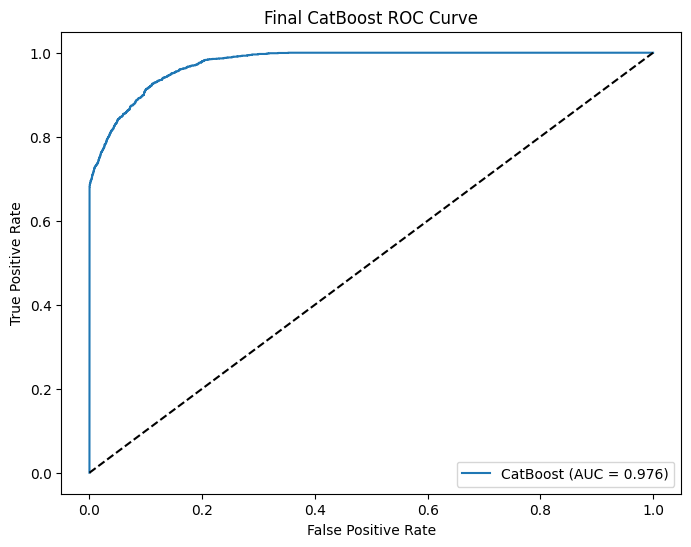

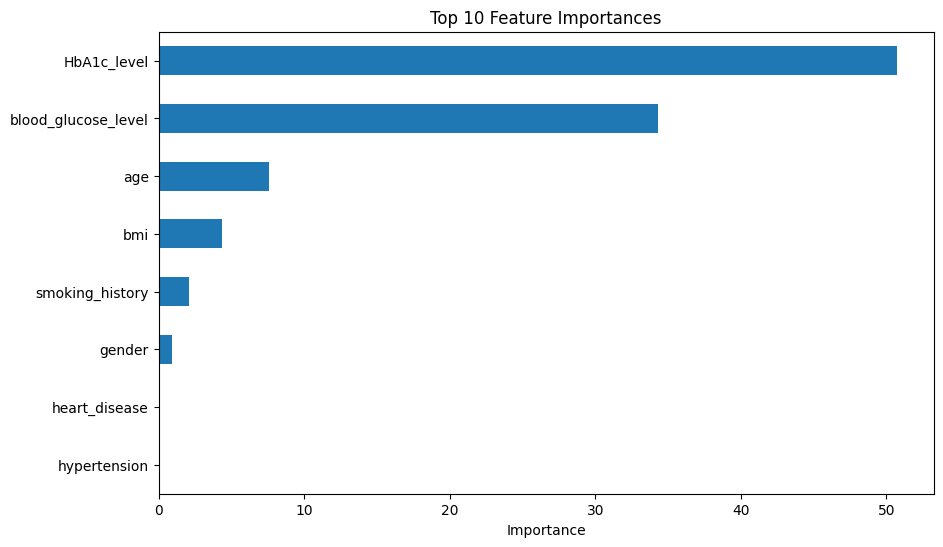

Cross-validated AUC: 0.969


In [10]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

# Load dataset
df = pd.read_csv("/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv")

# Drop duplicates and missing values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Separate features and target
y = df['diabetes']
X = df.drop(columns=['diabetes'])

# Label-encode categorical features
label_encoder = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_encoder.fit_transform(X[col])

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Optional: remove outliers using IQR on numeric features
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
Q1 = X_train[numeric_cols].quantile(0.25)
Q3 = X_train[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
mask = ((X_train[numeric_cols] < (Q1 - 1.5 * IQR)) |
        (X_train[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
X_train_clean = X_train.loc[~mask].reset_index(drop=True)
y_train_clean = y_train.loc[~mask].reset_index(drop=True)

# Hyperparameter tuning with GridSearchCV (single job to avoid pickling issues)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0]
}
cb = CatBoostClassifier(
    random_seed=42,
    logging_level='Silent',
    loss_function='Logloss'
)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=cb,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=1,
    verbose=1
)
grid.fit(X_train_clean, y_train_clean)
print("Best Params:", grid.best_params_)

# Train final model with early stopping
best_params = grid.best_params_
final_model = CatBoostClassifier(
    **best_params,
    random_seed=42,
    logging_level='Silent',
    loss_function='Logloss'
)
final_model.fit(
    X_train_clean, y_train_clean,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,
    use_best_model=True
)

# Predict on test set
y_pred = final_model.predict(X_test)
y_pred_prob = final_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Final CatBoost Accuracy: {acc:.3f}")
print(f"Final CatBoost AUC: {auc:.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final CatBoost ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature importance plot
importances = final_model.get_feature_importance()
feat_names = X.columns.tolist()
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feat_imp[:10].plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

# Cross-validation of final model AUC
cv_auc = np.mean(
    [roc_auc_score(
         y_train_clean.iloc[val_idx],
         final_model.predict_proba(X_train_clean.iloc[val_idx])[:, 1]
     ) for _, val_idx in cv.split(X_train_clean, y_train_clean)]
)
print(f"Cross-validated AUC: {cv_auc:.3f}")


In [11]:
# Save the trained model to a file
model_filename = "/kaggle/working/catboost_model.cbm"
final_model.save_model(model_filename)

print(f"Model saved as {model_filename}")


Model saved as /kaggle/working/catboost_model.cbm
